# 4. Design and implement a CNN for Image Classification a) Select a suitable image classification dataset (medical imaging, agricultural, etc.). b) Optimized with different hyper-parameters including learning rate, filter size, no. of layers, optimizers, dropouts, etc.

# Download Dataset from Kaggle link : https://www.kaggle.com/datasets/ayanwap7/rice-image-dataset-train-test-split/data

Found 48000 images belonging to 5 classes.
Found 12000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Epoch 1/5


C:\Users\21118\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\21118\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 403s 268ms/step - accuracy: 0.8820 - loss: 0.3200 - val_accuracy: 0.9649 - val_loss: 0.1053
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 405s 270ms/step - accuracy: 0.9621 - loss: 0.1137 - val_accuracy: 0.9884 - val_loss: 0.0366
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 397s 265ms/step - accuracy: 0.9803 - loss: 0.0624 - val_accuracy: 0.9928 - val_loss: 0.0238
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 396s 264ms/step - accuracy: 0.9869 - loss: 0.0426 - val_accuracy: 0.9941 - val_loss: 0.0226
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 396s 264ms/step - accuracy: 0.9893 - loss: 0.0353 - val_accuracy: 0.9934 - val_loss: 0.0223
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step


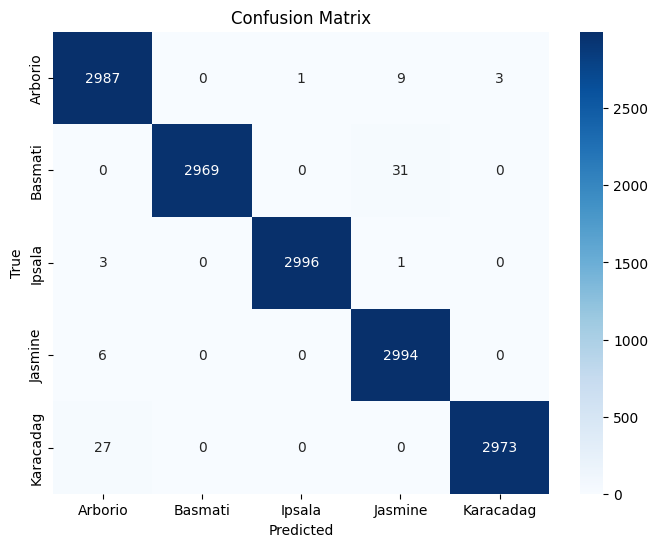

Classification Report:
               precision    recall  f1-score   support

     Arborio       0.99      1.00      0.99      3000
     Basmati       1.00      0.99      0.99      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.99      1.00      0.99      3000
   Karacadag       1.00      0.99      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import shutil
import pathlib

# Set paths
base_dir = "rice/Rice_Image_Dataset/"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Create a validation directory by splitting training data (80/20)
val_dir = os.path.join(base_dir, "validation")
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

    for class_folder in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_folder)
        files = os.listdir(class_path)
        np.random.shuffle(files)

        val_count = int(len(files) * 0.2)
        val_files = files[:val_count]

        # Create val/class folders
        os.makedirs(os.path.join(val_dir, class_folder), exist_ok=True)

        for file in val_files:
            shutil.move(os.path.join(class_path, file),
                        os.path.join(val_dir, class_folder, file))

# Data generators
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=1, class_mode='categorical', shuffle=False)

# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_data, epochs=5, validation_data=val_data, callbacks=[early_stop])

# Evaluation on test data
test_preds = model.predict(test_data)
predicted_classes = np.argmax(test_preds, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)
